# gQuant - Making Quantitative Analysis Faster

## Background
By definition, **Quantitative Finance** is the use of mathematical models and large datasets to analyze financial markets and securities, requiring massive computation to extract insight from the data. 

Many data science toolkits have been developed to help data scientists to manipulate the data. It starts with scalar number computations at the beginning. Later, the development of [Numpy](https://www.numpy.org) library helps to operate the numbers at vectors, and the popular [Pandas](https://pandas.pydata.org) library operates at a dataframe level. Manipulating data at a high level brings productivity gain for data scientists in quantitative finance.

However, the amount of collected data is increasing exponentially over time.  Also, more and more machine learning and statistical models are being developed. As a result, data scientists are facing new challenges hard to deal with traditional data science libraries.

It is very time-consuming for CPUs to crunch massive amount of data and compute the complicated data science models. Large data set requires distributed computation, which is too complicated for data scientists to adopt.

As a consequence, the quantitative workflow has become more complicated than ever. It integrates massive data from different sources, requiring multiple iterations to obtain significative results. 

**gQuant** has been developed to address all these challenges by organizing dataframes into graphs. It introduces the idea of **dataframe-flow**, which manipulates dataframes at graph level. An **acyclic directed graph** is defined, where the nodes are dataframe processors and the edges are the directions of passing resulting dataframes.

With a graph approach, quant's workflow is described at a high level, letting quant analysts address the complicated workflow challenge.

It is GPU-accelerated by leveraging [RAPIDS.ai](https://rapids.ai) technology and has **Multi-GPU and Multi-Node support**.

We can get orders of magnitude performance boosts compared to CPU. gQuant dataframe-flow is **dataframe agnostic**, and can flow:
- Pandas dataframe, computed in the CPU.
- cuDF dataframe, computed in the GPU and producing the same result but much faster.
- dask_cuDF dataframe, being the computation automatically executed on multiple nodes and multiple GPUs.

## Download example datasets

Before getting started, let's download the example datasets if not present.

In [1]:
! ((test ! -f './data/stock_price_hist.csv.gz' ||  test ! -f './data/security_master.csv.gz') && \
  cd .. && bash download_data.sh) || echo "Dataset is already present. No need to re-download it."

Dataset is already present. No need to re-download it.


## Prepare for running in Dask environment

Let's start the Dask local cluster environment for distributed computation.

Dask provides a web-based dashboard to help to track progress, identify performance issues, and debug failures. To learn more about Dask dashboard, just follow this [link](https://distributed.dask.org/en/latest/web.html).


In [2]:
# Start the Dask local cluster environment for distrubuted computation
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster()
client = Client(cluster)
client


Client Scheduler: tcp://127.0.0.1:43909 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 100.00 GB


Though our stock dataset is small enough to fit in a single 16G GPU, to show how to do distributed computation, we will split the dataframe into small pieces to be loaded by different workers in the cluster.

Notice this step is need only if the dataset is not split in multiple files yet.

First use this simple taskgraph to load data then sort it by the asset id and datatime:

In [3]:
import sys; sys.path.insert(0, '..')
from gquant.dataframe_flow import TaskGraph
task_graph = TaskGraph.load_taskgraph('../taskgraphs/sort_stocks.gq.yaml')
input_cached, = task_graph.run()
task_graph.draw()

GQuantWidget(sub=HBox(), value=[OrderedDict([('id', 'stock_data'), ('type', 'CsvStockLoader'), ('conf', {'file…

convert the sorted stock data into partitions and save it into csv files. Note, the data is slited in a way that the same asset belongs to the same partition

In [4]:
import dask.dataframe as dd
import os
num_partitions = 8

os.makedirs('many-small', exist_ok=True)
dd.from_pandas(input_cached.set_index('asset'), npartitions=num_partitions).reset_index().to_csv('many-small/*.csv', index=False)

['/home/quant/gQuant/notebooks/many-small/0.csv',
 '/home/quant/gQuant/notebooks/many-small/1.csv',
 '/home/quant/gQuant/notebooks/many-small/2.csv',
 '/home/quant/gQuant/notebooks/many-small/3.csv',
 '/home/quant/gQuant/notebooks/many-small/4.csv',
 '/home/quant/gQuant/notebooks/many-small/5.csv',
 '/home/quant/gQuant/notebooks/many-small/6.csv',
 '/home/quant/gQuant/notebooks/many-small/7.csv']

## The toy example
In this notebook, we will use a simple toy example to show how easy it is to accelerate the quant workflow in the GPU.

To mimic the end-to-end quantitative analyst task, we are going to backtest a simple mean reversion trading strategy.

The workflow can be divided into two steps. You can follow with me with an empty gQuant widget to build the TaskGraph:

In [4]:

task_graph = TaskGraph()
task_graph.draw()

GQuantWidget(sub=HBox())

### Preprocess the dataset to remove bad points and add return feature


1. Load the 5000 end-of-day stocks CSV data into the dataframe and add rate of return feature to the dataframe.
<img src='images/portfolio/add_indicator.gif'  align="center" />

2. Compute the average volume, min/max returns for each of the stocks
<img src='images/portfolio/add_volume_min_max_return.gif'  align="center" />

3. Merge the features into one dataframe, clean up the data by removing low volume stocks and extreme rate of returns stocks.
<img src='images/portfolio/filter_value.gif'  align="center" />

4. Create a composite node for this preprocess task
<img src='images/portfolio/create_composite.gif'  align="center" />

### Apply simple mean reversion algorithm and run backtest

1. Clean up the nodes for the backtest
<img src='images/portfolio/clean_up_for_backtest.gif'  align="center" />

2. Compute the slow and fast exponential moving average and compute the trading signal based on it. Run backtesting and compute the returns from this strategy for each of the days and stock symbols. Run a simple portfolio optimization by averaging the stocks together for each of the trading days. Compute the sharpe ratio and cumulative return results.
<img src='images/portfolio/backtest.gif'  align="center" />

3. Change the `slow`, `fast` parameters for the trading stratiges and re-run the backtest
<img src='images/portfolio/change_parameters.gif'  align="center" />

4. Switch to run the backtest in a distributed environment by Dask
<img src='images/portfolio/run_dask_trade.gif'  align="center" />

5. As a reference, switch to run the backtest in a CPU environment by Pandas
<img src='images/portfolio/run_pandas.gif'  align="center" />

The whole workflow is organized into a TaskGraph file, which is described in a **gq.yaml** file.

The same taskgraphs are saved in the `taskgraphs` directories. The whole workflow can be organized into a computation graph, which is described in a **yaml** file. 

Here is snippet of the yaml file:

In [5]:
!head -n 18 ../taskgraphs/portfolio_trade.gq.yaml
print("...")

- id: stock_data
  type: CsvStockLoader
  conf:
    file: notebooks/data/stock_price_hist.csv.gz
    path: notebooks/many-small
  inputs: {}
- id: preprocess
  type: CompositeNode
  conf:
    subnode_ids:
      - value_filter
    subnodes_conf:
      value_filter:
        conf:
          - column: min_return
            min: -10
          - column: max_return
            max: 10
...



Lode the preprocess TaskGraph by `load_taskgraph` command

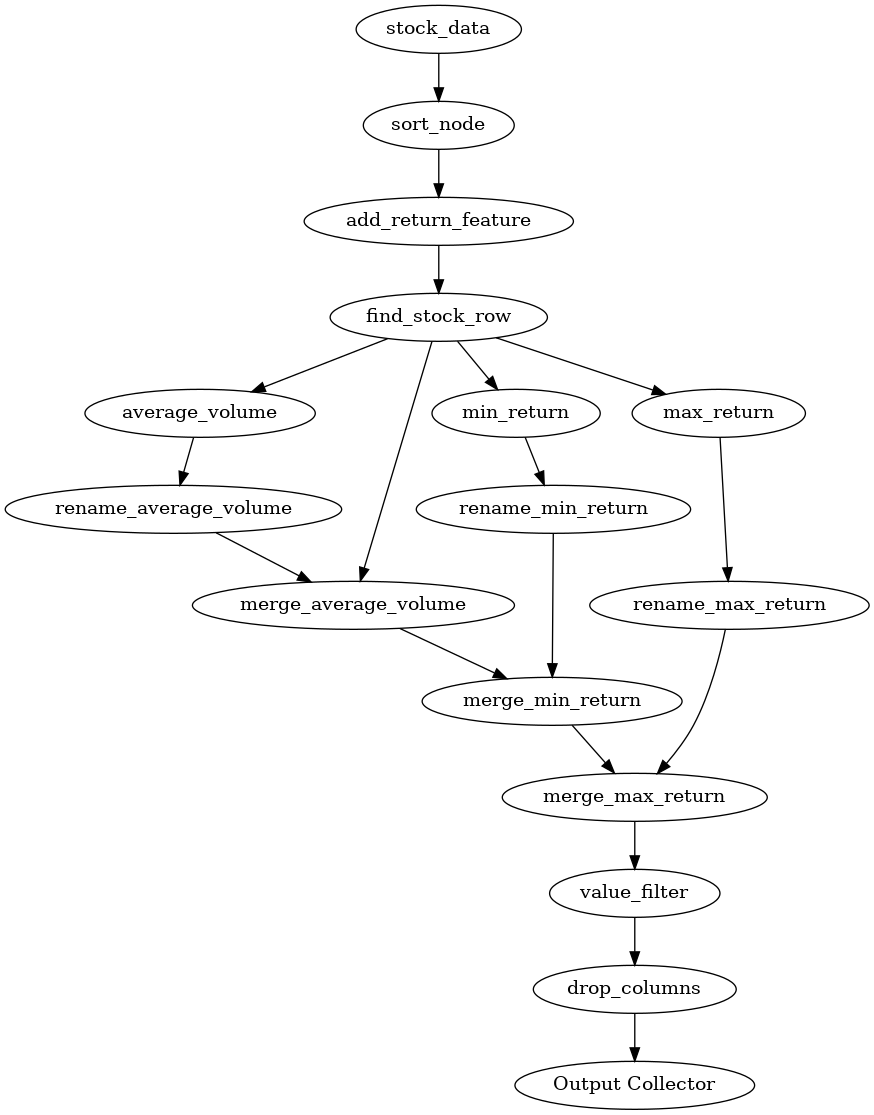

In [6]:
task_graph = TaskGraph.load_taskgraph('../taskgraphs/preprocess.gq.yaml')
task_graph.draw(show='ipynb')

It can be shown in the interactive gQuant widget. Try to run it and see the preprocess results:

In [7]:
task_graph.draw()

GQuantWidget(sub=HBox(), value=[OrderedDict([('id', 'stock_data'), ('type', 'CsvStockLoader'), ('conf', {'file…

Lode the whole TaskGraph by `load_taskgraph` command

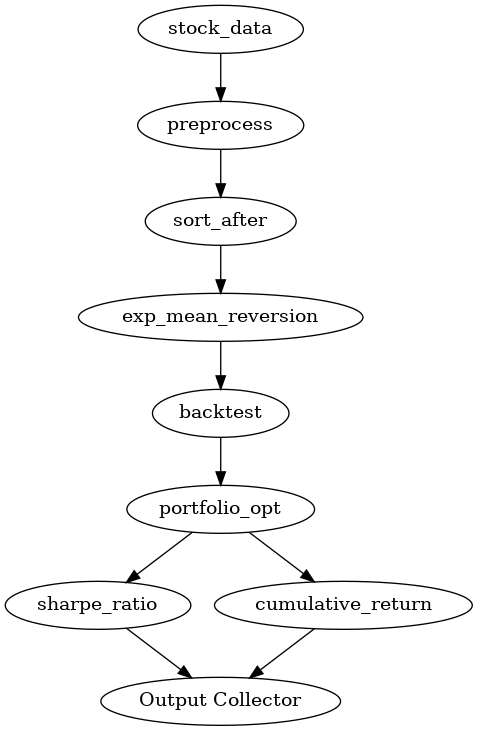

In [8]:
task_graph = TaskGraph.load_taskgraph('../taskgraphs/portfolio_trade.gq.yaml')
task_graph.draw(show='ipynb')

To see the input/output ports of the nodes, turn `show_ports` flag on

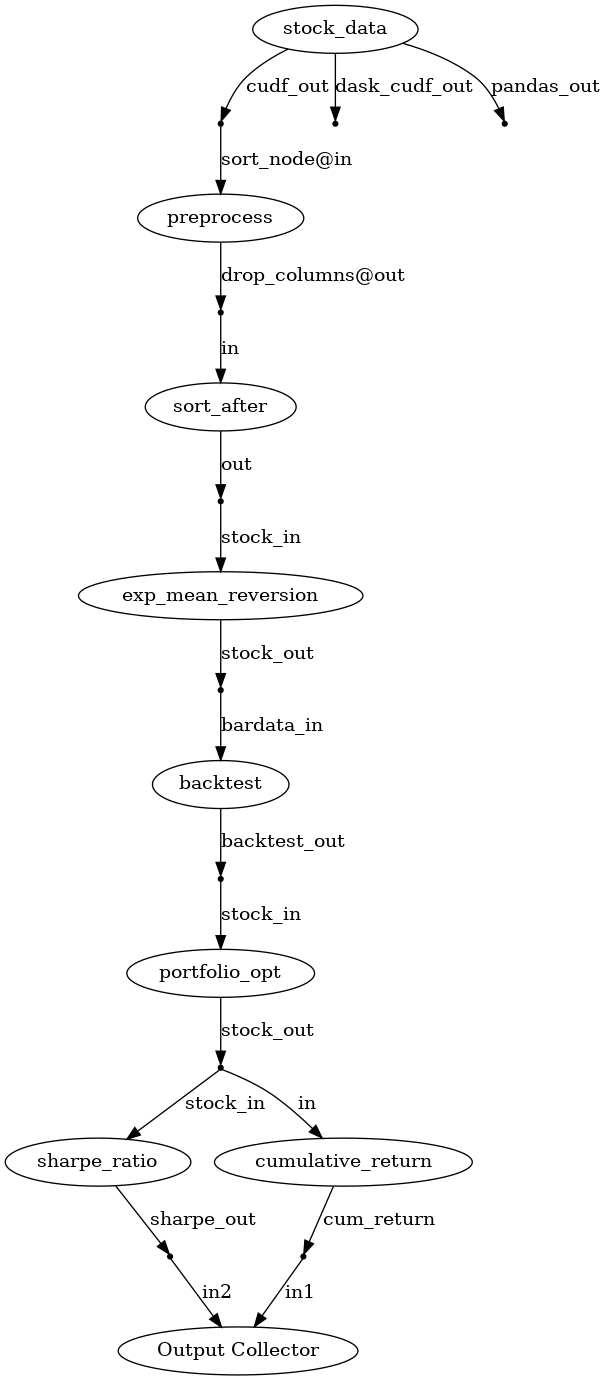

In [9]:
task_graph.draw(show='ipynb', show_ports=True)

Similarly, it can be shown in the interactive gQuant widget. Try to run it, change the parameters and play with it as shown in the animation:

In [10]:
task_graph.draw()

GQuantWidget(sub=HBox(), value=[OrderedDict([('id', 'stock_data'), ('type', 'CsvStockLoader'), ('conf', {'file…

Running this toy example in a Dask distributed environment is super easy, as gQuant operates at dataframe level.

We just need to swap cuDF dataframes to **dask_cuDF** dataframes. Try to connect the `preprocess` node to the `Dask dataframe` output port in the `stock data` node.

Similarly, to see how fast the GPU acceleration is, we can swtich to CPU computation environment by connecting to the `Pandas dataframe` output port.

## Benchmarks

While running this notebook, we have obtained the following results:

- 181.00 seconds to run in CPU (Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz).
-   9.06 seconds to run in GPU (NVIDIA v100).

We get ~20x speed up by using GPU and GPU dataframes, compared to CPU and CPU dataframes.


## GQuant Task Node 

Each node is composed of:
- a unique id,
- a node type, 
- configuration parameters
- from zero to many input nodes ids.

gQuant's `load_taskgraph` takes this yaml file, and wires it into a graph.

gQuant implementation includes some common nodes, useful for quantitative finance. With the help of [Numba](https://numba.pydata.org) library, we have implemented more than 30 technical indicators used in computing trading signals. All of them computed in the GPU.

However, gQuant's goal is not to be comprehensive for quant applications. It provides a framework that is easy for anyone to implement his own nodes in the gQuant.


Data scientists only need to override five methods in the parent class `Node`:
- `init`
- `columns_setup`
- `ports_setup`
- `conf_schema`
- `process`

`init` method is usually used to define the required column names

`ports_setup` defines the input and output ports for the node

`columns_setup` method is used to calculate the output column name and types.

`conf_schema` method is used to define the JSON schema for the node conf so the client can generate the proper UI for it.

`process` method takes input dataframes and computes the output dataframe. 

In this way, dataframes are strongly typed, and errors can be detected early before the time-consuming computation happens.

Here is the code example for implementing `MaxNode`, which is to compute the maximum value for a specified column in the dataframe.

In [11]:
from gquant.dataframe_flow import Node
from gquant.dataframe_flow._port_type_node import _PortTypesMixin
from gquant.dataframe_flow.portsSpecSchema import ConfSchema


class MaxNode(Node, _PortTypesMixin):

    def init(self):
        _PortTypesMixin.init(self)
        self.INPUT_PORT_NAME = 'in'
        self.OUTPUT_PORT_NAME = 'out'
        cols_required = {"asset": "int64"}
        self.required = {
            self.INPUT_PORT_NAME: cols_required
        }

    def ports_setup(self):
        return _PortTypesMixin.ports_setup(self)

    def conf_schema(self):
        json = {
            "title": "Maximum Value Node configure",
            "type": "object",
            "description": "Compute the maximum value of the key column",
            "properties": {
                "column":  {
                    "type": "string",
                    "description": "column to calculate the maximum value"
                }
            },
            "required": ["column"],
        }
        input_columns = self.get_input_columns()
        if self.INPUT_PORT_NAME in input_columns:
            col_from_inport = input_columns[self.INPUT_PORT_NAME]
            enums = [col for col in col_from_inport.keys()]
            json['properties']['column']['enum'] = enums
            ui = {}
            return ConfSchema(json=json, ui=ui)
        else:
            ui = {
                "column": {"ui:widget": "text"}
            }
            return ConfSchema(json=json, ui=ui)

    def process(self, inputs):
        """
        Compute the maximum value of the key column which is defined in the
        `column` of the node's conf

        Arguments
        -------
         inputs: list
            list of input dataframes.
        Returns
        -------
        dataframe
        """
        input_df = inputs[self.INPUT_PORT_NAME]
        max_column = self.conf['column']
        volume_df = input_df[[max_column,
                              "asset"]].groupby(["asset"]).max().reset_index()
        volume_df.columns = ['asset', max_column]
        return {self.OUTPUT_PORT_NAME: volume_df}

    def columns_setup(self):
        if 'column' in self.conf:
            retention = {self.conf['column']: "float64",
                         "asset": "int64"}
            return _PortTypesMixin.retention_columns_setup(self,
                                                           retention)
        else:
            retention = {"asset": "int64"}
            return _PortTypesMixin.retention_columns_setup(self,
                                                           retention)


In case that there is no direct dataframe method for a particular logic, a Numba GPU kernel can be used to implement it. Some examples of customized GPU kernels in Numba can be found [here](https://github.com/rapidsai/gQuant/blob/master/notebooks/05_customize_nodes.ipynb).

If we use customized GPU kernel functions inside the `process` method to process the dataframe instead of _normal_ dataframe API functions calls,  we need to add `self.delayed_process = True` in the `columns_setup` method to let gQuant handle the dask graph integration problem. If we use  _normal_ dataframe API functions inside the `process` method, nothing needs to be done as `self.delayed_process = False` by default.bgQuant automatically handles the complication of including a customized GPU kernel node into the Dask computation graph.

Note, we set `self.delayed_process = True` for the `SortNode`. So th sort is performed at the Dask data partition level instead of sorting it globally. This has a benefits of guranteeing the sortting doens't pollute the data partition allocation, as sometimes we want to make sure the data partition remain the same during the distributed computation. 

## Running the TaskGraph programmatically


To run the TaskGraph programmatically , we can specifiy a list of output ports to the TaskGraph `run` method. The `profile` flag can be used to see the computation time spent on each of the nodes:

In [12]:
import warnings; warnings.simplefilter("ignore")

o_gpu = task_graph.run(
            outputs=['sharpe_ratio.sharpe_out', 'cumulative_return.cum_return','stock_data.cudf_out', 'preprocess.drop_columns@out'], profile=True)
gpu_strategy_cached = o_gpu['preprocess.drop_columns@out'] 
gpu_input_cached = o_gpu['stock_data.cudf_out']  

id:stock_data process time:4.034s
id:preprocess process time:7.638s
id:backtest process time:0.012s
id:portfolio_opt process time:0.041s
id:sharpe_ratio process time:0.378s
id:cumulative_return process time:0.436s


`o_gpu` will contain the outputs of four nodes: `sharpe_ratio`, `cumlative_return`, `stock_data`, `preprocess`.

Similarly, the output from `stock_data` and `preprocess` nodes will be cached stored in `gpu_input_cached` and `strategy_cached` variables for later use. 

We can check how many of the stocks are filtered out by preprocessing steps:

In [13]:
print("{} stocks in original dataset.".format(len(gpu_input_cached['asset'].unique())))
print("{} stocks remaining after filtering.".format(len(gpu_strategy_cached['asset'].unique())))

5052 stocks in original dataset.
1558 stocks remaining after filtering.


The result can be shown in IPython Rich display by turnning on the `formatted` flag:

In [14]:
task_graph.run(
            outputs=['sharpe_ratio.sharpe_out', 'cumulative_return.cum_return','preprocess.drop_columns@out'], formated=True)

This toy strategy gets a Sharpe ratio 0.338 without considering the transaction cost. Nice! 

[bqplot](https://github.com/bloomberg/bqplot) library is used to visualize the backtesting results in the JupyterLab notebooks. 

In [15]:
# define the function to format the plots
def plot_figures(outputs):
    # format the figures
    figure_width = '1200px'
    figure_height = '400px'
    sharpe_number = outputs[0]
    cum_return = outputs[1]
    cum_return.layout.height = figure_height
    cum_return.layout.width = figure_width
    cum_return.title = 'P & L %.3f' % (sharpe_number)
    return cum_return

plot_figures(o_gpu)

Figure(axes=[Axis(label='Cumulative return', orientation='vertical', scale=LinearScale(), side='left'), Axis(l…

gQuant TaskGraph can be evaluated by overwritting any of the Node's parameters. E.g. we can change the parameters to filter out the stocks:

In [16]:
# Define some constants for the data filters.
# If using a GPU of 32G memory, you can safely 
# set the `min_volume` to 5.0
min_volume = 10.0
min_rate = -10.0
max_rate = 10.0

In [18]:
%%time
o_gpu = task_graph.run(
            outputs=['sharpe_ratio.sharpe_out', 'cumulative_return.cum_return', 'stock_data.cudf_out', 'preprocess.drop_columns@out'],    
            replace={'preprocess': {"conf": {
                                        "subnodes_conf": {
                                            "value_filter": {
                                                "conf": [{"column": "average_volume", "min": min_volume},
                                                         {"column": "max_return", "max": max_rate},
                                                         {"column": "min_return", "min": min_rate}]
                                            }
                                         },
                                        "taskgraph": "taskgraphs/preprocess.gq.yaml",
                                        "input": ["sort_node.in"],
                                        "output": ["drop_columns.out"]
                                    }}
                    }, profile=True)

gpu_input_cached = o_gpu['stock_data.cudf_out']  
gpu_strategy_cached = o_gpu['preprocess.drop_columns@out'] 
print("{} stocks in original dataset.".format(len(gpu_input_cached['asset'].unique())))
print("{} stocks remaining after filtering.".format(len(gpu_strategy_cached['asset'].unique())))
plot_figures(o_gpu)

id:stock_data process time:4.129s
id:preprocess process time:7.472s
id:backtest process time:0.012s
id:portfolio_opt process time:0.042s
id:sharpe_ratio process time:0.390s
id:cumulative_return process time:0.423s
5052 stocks in original dataset.
4405 stocks remaining after filtering.
CPU times: user 9.83 s, sys: 879 ms, total: 10.7 s
Wall time: 17 s


Figure(axes=[Axis(label='Cumulative return', orientation='vertical', scale=LinearScale()), Axis(label='Time', …

In the example above, `preprocess` node is a composite node that use a seperate TaskGraph as input and output. Any of the node inside the composite node TaskGraph configuration can be overridden as shown in the example. We change the `filter_value` node configuration  inside the composite node to filter out the stocks that are not suitable for backtesting. It will discard stocks according to the values stored in `min_volume`, `min_rate`, and `max_rate` variables.



Next, we are going to compare the performance difference between CPU and GPU. The same computation graph can be used to flow the CPU Pandas dataframe with one change that
the preprocess node need to get input from the Pandas dataframe:

In [19]:
%%time

o_cpu = task_graph.run(
            outputs=['sharpe_ratio.sharpe_out', 'cumulative_return.cum_return'],    
            replace={'preprocess': {"inputs": {"sort_node@in": "stock_data.pandas_out"}}}, profile=True)

id:stock_data process time:105.615s
id:preprocess process time:26.043s
id:sort_after process time:1.493s
id:exp_mean_reversion process time:10.645s
id:backtest process time:0.043s
id:portfolio_opt process time:0.474s
id:sharpe_ratio process time:0.001s
id:cumulative_return process time:0.020s
CPU times: user 2min 13s, sys: 15 s, total: 2min 28s
Wall time: 2min 24s


In [20]:
plot_figures(o_cpu)

Figure(axes=[Axis(label='Cumulative return', orientation='vertical', scale=LinearScale(), side='left'), Axis(l…

It produces the same result as the single GPU version but a lot slower.

While running this notebook, we have obtained the following results:

- 181.00 seconds to run in CPU (Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz).
-   9.06 seconds to run in GPU (NVIDIA v100).

We get ~20x speed up by using GPU and GPU dataframes, compared to CPU and CPU dataframes.

Note, the input nodes load the dataframes from the cache variables to save the disk IO time.

The distributed computation is turned on by changing the preprocess node's input dataframe to dask dataframe: 

In [21]:
%%time
o_dask = task_graph.run(
            outputs=['sharpe_ratio.sharpe_out', 'cumulative_return.cum_return'],    
            replace={'preprocess': {"inputs": {"sort_node@in": "stock_data.dask_cudf_out"}}}, profile=True)
plot_figures(o_dask)

id:stock_data process time:0.124s
id:preprocess process time:7.092s
id:backtest process time:0.013s
id:portfolio_opt process time:0.043s
id:sharpe_ratio process time:0.376s
id:cumulative_return process time:0.426s
CPU times: user 5.15 s, sys: 339 ms, total: 5.49 s
Wall time: 11.6 s


Figure(axes=[Axis(label='Cumulative return', orientation='vertical', scale=LinearScale()), Axis(label='Time', …

Again, it produces the same results. However, the performance is not better than in the single GPU scenarios.

Distributed computation only makes sense if we have a very large dataset that cannot be fit into one GPU.

In this example, the dataset is small enough to be loaded into a single GPU. The between-GPU communication overhead dominates in the computation.

## Strategy parameter search
Quantitative analysts often need to explore different parameters for their trading strategy.

gQuant speeds up this iterative exploration process by using cached dataframes and sub-graphs evaluation.

To find the optimal parameters for this toy mean reversion strategy, we only need the dataframe from `sort_2` node, which is cached in the `gpu_strategy_cached` variable.

Because the GPU computation is so fast, we can make the parameter exploration interactive in the JupyterLab notebook:

In [23]:
import ipywidgets as widgets

para_selector = widgets.IntRangeSlider(value=[10, 30],
                                       min=3,
                                       max=60,
                                       step=1,
                                       description="MA:",
                                       disabled=False,
                                       continuous_update=False,
                                       orientation='horizontal',
                                       readout=True)


def para_selection(*stocks):
    with out:
        para1 = para_selector.value[0]
        para2 = para_selector.value[1]
        o = task_graph.run(
                outputs=['sharpe_ratio.sharpe_out', 'cumulative_return.cum_return'],
                replace={'exp_mean_reversion': {'conf':  {'fast': para1,
                                                          'slow': para2}},
                         'preprocess': {"load": {"drop_columns@out": gpu_strategy_cached},
                                        "conf": {
                                        "subnodes_conf": {
                                            "value_filter": {
                                                "conf": [{"column": "average_volume", "min": min_volume},
                                                         {"column": "max_return", "max": max_rate},
                                                         {"column": "min_return", "min": min_rate}]
                                            }
                                         },
                                        "taskgraph": "taskgraphs/preprocess.gq.yaml",
                                        "input": ["sort_node.in"],
                                        "output": ["drop_columns.out"]
                                    }}})

        figure_combo = plot_figures(o)
        w.children = (w.children[0], figure_combo,)


out = widgets.Output(layout={'border': '1px solid black'})
para_selector.observe(para_selection, 'value')
selectors = widgets.HBox([para_selector])
w = widgets.VBox([selectors])
w

In [34]:
out

Output(layout=Layout(border='1px solid black'))